In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df_item = pd.read_csv('input/item-features.csv')
df_user = pd.read_csv('input/user-features.csv')
subm = pd.read_csv('input/sample-submission.csv')

In [79]:
df_item = df_item.drop(columns=['19','27','30','9'])
df_item = df_item.sort_values('item_id').reset_index(drop=True)

df_user = df_user.iloc[:, :3]
df_user = df_user.sort_values('user_id').reset_index(drop=True)

In [80]:
train.head()

,user_id,item_id,like,timestamp
0,140,342,0,1490936622
1,378,172,1,1490936628
2,150,182,0,1490936650
3,455,17,0,1490936704
4,350,409,0,1490936735


In [81]:
from scipy.sparse import csr_matrix

df_user_np = df_user.iloc[:, 1:]
df_item_np = df_item.iloc[:, 1:]

y = train['like'].map({0: -1, 1:1}).to_numpy()
X_train = train.drop(columns=['like'])

data_csr = csr_matrix((y, (X_train['user_id'] , X_train['item_id'])))
df_user_np.shape, df_item_np.shape, data_csr.shape

((497, 2), (444, 28), (497, 444))

In [82]:
data_csr[0, 0], data_csr[378, 172], data_csr[140, 342]

(0, 1, -1)

In [83]:
from  sklearn.metrics.pairwise import pairwise_distances

# считаем косинусное расстояние для пользователей и фильмов 
# (построчно и поколоночно соотвественно).
user_similarity = pairwise_distances(df_user_np, metric='cosine')
item_similarity = pairwise_distances(df_item_np, metric='cosine')
user_similarity.shape, item_similarity.shape

((497, 497), (444, 444))

# Article
https://makesomecode.me/2018/09/movie-recommendation-system/

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    # Оставим оценки, предсказанные алгоритмом, только для соотвествующего набора данных
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    # Оставим оценки, которые реально поставил пользователь, только для соотвествующего набора данных
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    
    mse = mean_squared_error(prediction, ground_truth)
    return sqrt(mse)

In [92]:
n_users = 497
n_movies = 444

train_data_matrix = data_csr.toarray()
test_data_matrix = data_csr.toarray()

In [94]:
def k_fract_mean_predict(top):
    top_similar = np.zeros((n_users, top))
    
    for i in range(n_users):
        user_sim = user_similarity[i]
        top_sim_users = user_sim.argsort()[1:top + 1]

        for j in range(top):
            top_similar[i, j] = top_sim_users[j]
            
    abs_sim = np.abs(user_similarity)
    pred = np.zeros((n_users, n_movies))
    
    for i in range(n_users):
        indexes = top_similar[i].astype(np.int)
        numerator = user_similarity[i][indexes]
        
        mean_rating = np.array([x for x in train_data_matrix[i] if x > 0]).mean()
        diff_ratings = train_data_matrix[indexes] - train_data_matrix[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        
        pred[i] = mean_rating + numerator / denominator
        
    return pred

def k_fract_mean_predict_item(top):
    top_similar = np.zeros((n_movies, top))
    
    for i in range(n_movies):
        movie_sim = item_similarity[i]
        top_sim_movies = movie_sim.argsort()[1:top + 1]
        
        for j in range(top):
            top_similar[i, j] = top_sim_movies[j]
    
    abs_sim = np.abs(item_similarity)
    pred = np.zeros((n_movies, n_users))
    
    for i in range(n_movies):
        indexes = top_similar[i].astype(np.int)
        numerator = item_similarity[i][indexes]
        
        diff_ratings = train_data_matrix.T[indexes] - train_data_matrix.T[indexes].mean()
        numerator = numerator.dot(diff_ratings)
        denominator = abs_sim[i][top_similar[i].astype(np.int)].sum()
        denominator = denominator if denominator != 0 else 1
        
        mean_rating = np.array([x for x in train_data_matrix.T[i] if x > 0]).mean()
        mean_rating = 0 if np.isnan(mean_rating) else mean_rating
        pred[i] = mean_rating + numerator / denominator
                
    return pred.T

k_predict = k_fract_mean_predict(20)
print('User-based CF RMSE: ', rmse(k_predict, test_data_matrix))

k_predict_item = k_fract_mean_predict_item(20)
print('Item-based CF RMSE: ', rmse(k_predict_item, test_data_matrix))

C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


User-based CF RMSE:  1.0067670573752832


C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice.
C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Item-based CF RMSE:  1.4781127029402863


# Surprise

In [119]:
from surprise import NormalPredictor, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

In [115]:
train.head()

,user_id,item_id,like,timestamp
0,140,342,0,1490936622
1,378,172,1,1490936628
2,150,182,0,1490936650
3,455,17,0,1490936704
4,350,409,0,1490936735


In [114]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(train[['user_id', 'item_id', 'like']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(SVD(), data, cv=5)

{'test_rmse': array([0.28480864, 0.28737401, 0.29640801, 0.28969182, 0.29218496]),
 'test_mae': array([0.17720405, 0.17962929, 0.18028459, 0.18070854, 0.1839145 ]),
 'fit_time': (0.39881157875061035,
  0.3943197727203369,
  0.39627623558044434,
  0.39580821990966797,
  0.39583539962768555),
 'test_time': (0.008928060531616211,
  0.008928298950195312,
  0.009452104568481445,
  0.009424448013305664,
  0.008930683135986328)}

In [ ]:
# [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), 
#                   KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

# <class 'surprise.prediction_algorithms.matrix_factorization.SVD'> 0.1825750931054188
# <class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'> 0.16760332940541206
# <class 'surprise.prediction_algorithms.slope_one.SlopeOne'> 0.15265446170771874
# <class 'surprise.prediction_algorithms.random_pred.NormalPredictor'> 0.33987833116682625
# <class 'surprise.prediction_algorithms.knns.KNNBaseline'> 0.1297762283632601
# <class 'surprise.prediction_algorithms.knns.KNNBasic'> 0.1228509348207455
# <class 'surprise.prediction_algorithms.knns.KNNWithMeans'> 0.14724135594053778
# <class 'surprise.prediction_algorithms.knns.KNNWithZScore'> 0.14440677662246001
# <class 'surprise.prediction_algorithms.baseline_only.BaselineOnly'> 0.1839018552188873
# <class 'surprise.prediction_algorithms.co_clustering.CoClustering'> 0.15628048493380628

In [178]:
algos = [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(verbose=False), KNNBasic(verbose=False), 
         KNNWithMeans(verbose=False), KNNWithZScore(verbose=False), 
         BaselineOnly(verbose=False), CoClustering()]

for algorithm in algos:
    
    result = cross_validate(algorithm, data, cv=5)
    print(algorithm.__class__, result['test_mae'].mean())

<class 'surprise.prediction_algorithms.matrix_factorization.SVD'> 0.1825750931054188
<class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'> 0.16760332940541206
<class 'surprise.prediction_algorithms.slope_one.SlopeOne'> 0.15265446170771874
<class 'surprise.prediction_algorithms.random_pred.NormalPredictor'> 0.33987833116682625
<class 'surprise.prediction_algorithms.knns.KNNBaseline'> 0.1297762283632601
<class 'surprise.prediction_algorithms.knns.KNNBasic'> 0.1228509348207455
<class 'surprise.prediction_algorithms.knns.KNNWithMeans'> 0.14724135594053778
<class 'surprise.prediction_algorithms.knns.KNNWithZScore'> 0.14440677662246001
<class 'surprise.prediction_algorithms.baseline_only.BaselineOnly'> 0.1839018552188873
<class 'surprise.prediction_algorithms.co_clustering.CoClustering'> 0.15628048493380628


In [179]:
# 0.14098334301265458

algorithm = SVDpp(n_factors=5, lr_all=0.1, reg_all=0.02)  # , reg_all=0.02

result = cross_validate(algorithm, data, cv=5)
print(result['test_mae'].mean())

0.14792045242869906


In [186]:
# 0.11899593180524995

algorithm = KNNBasic(k=7, verbose=False)

res_sum = list()
for i in range(10):
    result = cross_validate(algorithm, data, cv=5)
    res_sum.append(result['test_mae'].mean())
print(np.mean(res_sum))

0.11949606732813518


In [212]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


algo = KNNBasic(k=7, verbose=False)
algo.fit(data.build_full_trainset())

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=20)
y_pred = pd.DataFrame.from_dict({k: [z[0] for z in v] for k, v in top_n.items()}).T.reset_index()
y_pred = y_pred.rename(columns={'index': 'user_id'})

# Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

In [214]:
subm.columns, y_pred.columns

(Index(['user_id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
        '12', '13', '14', '15', '16', '17', '18', '19'],
       dtype='object'),
 Index(['user_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19],
       dtype='object'))

In [216]:
subm.shape, y_pred.shape

((497, 21), (497, 21))

In [217]:
subm.iloc[:, 1:] = subm.iloc[:, :1].merge(y_pred, on='user_id').iloc[:, 1:].values

In [221]:
subm.to_csv('input/subm004.csv', index=None)

In [225]:
train[train.user_id==1]

,user_id,item_id,like,timestamp
298,1,54,0,1490945876
366,1,20,0,1490947707
1675,1,0,0,1490988759
2328,1,27,0,1491008981
2506,1,108,0,1491014450
3069,1,213,0,1491032049
3721,1,210,0,1491051735
4109,1,4,1,1491064028
4739,1,132,0,1491083480
5607,1,5,1,1491112270


In [223]:
subm.sort_values('user_id')

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
393,0,95,105,35,80,65,66,22,39,11,...,15,87,7,76,103,19,18,49,136,37
152,1,105,35,65,22,11,15,102,76,72,...,191,55,145,37,60,110,1,192,142,85
81,2,30,105,21,23,35,44,182,26,65,...,24,34,50,66,22,39,11,40,45,7
114,3,105,21,23,35,80,101,65,24,66,...,181,14,40,45,102,7,48,76,75,147
210,4,105,35,182,24,22,11,64,15,45,...,76,127,72,49,73,37,31,60,110,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,492,35,65,58,24,66,22,15,72,202,...,186,103,19,49,86,167,98,170,136,37
345,493,35,58,66,22,40,76,72,119,19,...,86,98,37,60,171,110,8,142,199,85
260,494,35,65,58,24,66,22,15,76,72,...,202,75,186,103,19,49,86,167,98,170
332,495,168,205,207,177,4,80,125,43,65,...,22,94,14,69,76,72,174,75,79,147


# LGB

In [300]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

import time

In [344]:
def predict_k(model, X_test, item_params, k=20):
    items_data = item_params.iloc[:, 1:].values
    n_items = len(item_params)
    y_pred = list()
    
    for user_idx in range(X_test.shape[0]):
#         result = pd.DataFrame(columns=['item_id', 'proba'])
#         result['item_id'] = range(n_items)
        
        user_data = np.tile(X_test[[user_idx]], (n_items, 1))
        data = np.concatenate([user_data, items_data], axis=1)
        
        pred = model.predict(data)
        y_pred.append(pred)
        
#         result['proba'] = model.predict(data)
#         result = result.sort_values('proba', ascending=False)
#         y_pred.append(result['item_id'].values)
        
    return np.array(y_pred)


def train_model(X, X_test, y, params, folds, model_type='lgb', averaging='usual', 
                verbose_eval=False, plot_feature_importance=False):
    oof = np.zeros(len(X))
    prediction = np.zeros((len(X_test), len(df_item)))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        if verbose_eval:
            print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
            valid_data = lgb.Dataset(X_valid, label=y_valid, params={'verbose': -1})
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=verbose_eval,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = predict_k(model, X_test, df_item)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = [f'col{ncol}' for ncol in range(X.shape[-1])]
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                   by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [361]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
# folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
# folds = TimeSeriesSplit(n_splits=n_fold)

In [377]:
params = {'boost': 'gbdt', 
          'feature_fraction': 0.5, 
          'lambda_l2': 0.57, 
          'learning_rate': 0.01, 
          'max_depth': 13, 
          'metric': 'auc', 
          'min_data_in_leaf': 63, 
          'num_leaves': 226, 
          'num_threads': -1, 
          'objective': 'binary', 
          'verbosity': -1}

In [407]:
X = X_train.values
y_like = y.values.flatten()
X_test_np = X_test.values
X.shape, X_test_np.shape

# X = X_train.values[:, 1:]
# y_like = y.values.flatten()
# X_test_np = X_test.values[:, 1:]
# X.shape, X_test_np.shape

((8674, 37), (497, 9))

CV mean score: 0.5594, std: 0.0207.


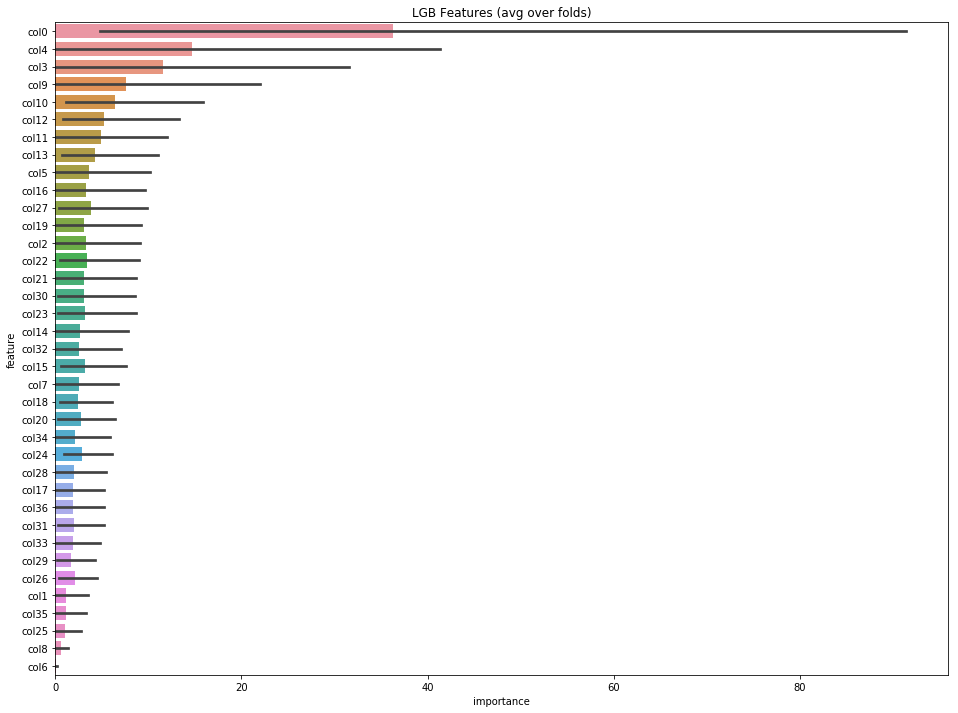

In [408]:
oof_lgb, prediction_lgb, scores = train_model(X, X_test_np, y_like, params=params, plot_feature_importance=True,
                                              folds=folds, model_type='lgb', verbose_eval=False)

In [393]:
pred = np.zeros((prediction_lgb.shape[0], 20), dtype=int)

for i in range(prediction_lgb.shape[0]):
    pred[i] = np.argsort(prediction_lgb[i])[::-1][:20]

# Hyperopt

In [335]:
from hyperopt import hp

In [338]:
def to_max(hp_params):
    oof_lgb, prediction_lgb, scores = train_model(X, X_test_np, y_like, params=hp_params, 
                                                  folds=folds, model_type='lgb')
    return -np.mean(scores)

lgb_params = {'boost': 'gbdt',
          'feature_fraction': hp.uniform('feature_fraction', 0.05, 1),
          'learning_rate': 0.01,
          'max_depth': hp.choice('max_depth', [5, 9, 13, 17, 23, -1]),  
          'metric': 'auc',
          'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 11, 151),
          'num_leaves': hp.uniformint('num_leaves', 31, 351),
          'num_threads': -1,
          'verbosity': -1,
          'lambda_l2': hp.uniform('lambda_l2', 0, 3),
          'objective': 'binary',
         }

In [339]:
# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(to_max, lgb_params, algo=tpe.suggest, max_evals=100)

print(best)
print(space_eval(lgb_params, best))

CV mean score: 0.5484, std: 0.0200.                                                                                    
CV mean score: 0.5467, std: 0.0220.                                                                                    
CV mean score: 0.5564, std: 0.0230.                                                                                    
CV mean score: 0.5495, std: 0.0140.                                                                                    
CV mean score: 0.5495, std: 0.0151.                                                                                    
CV mean score: 0.5576, std: 0.0178.                                                                                    
CV mean score: 0.5511, std: 0.0202.                                                                                    
CV mean score: 0.5544, std: 0.0140.                                                                                    
CV mean score: 0.5574, std: 0.0181.     

# First try

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.sparse import csr_matrix

scaler = MinMaxScaler()  # StandardScaler()
df_item_np = csr_matrix(scaler.fit_transform(df_item.iloc[:, 1:]))

# df_user_np = csr_matrix(df_user.iloc[:, [1]].values)
df_user_np = csr_matrix(scaler.fit_transform(df_user.iloc[:, [1]].values))

y_np = y.map({0:-1, 1:1}).values

data_csr = csr_matrix((y_np, (train['user_id'] , train['item_id'])))

from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
item_sim = linear_kernel(df_item_np, df_item_np)
item_sim = csr_matrix(item_sim)

In [409]:
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.evaluation import precision_at_k

In [443]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()  # StandardScaler()
df_item_np = csr_matrix(scaler.fit_transform(df_item.iloc[:, 1:]))

# df_user_np = csr_matrix(df_user.iloc[:, [1]].values)
df_user_np = csr_matrix(scaler.fit_transform(df_user.iloc[:, [1]].values))

y_np = y.map({0:-1, 1:1}).values

data_csr = csr_matrix((y_np, (train['user_id'] , train['item_id'])))

In [444]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
item_sim = linear_kernel(df_item_np, df_item_np)
item_sim = csr_matrix(item_sim)

In [428]:
model = LightFM(no_components=30, loss='warp')

In [429]:
# 0.08209256

model = LightFM(no_components=50, loss='warp', random_state=11)
model.fit(data_csr,
          user_features=df_user_np,
          item_features=df_item_np,
          epochs=50)

train_precision = precision_at_k(model, data_csr, user_features=df_user_np, item_features=df_item_np, k=20).mean()

print(train_precision)

0.08209256


In [261]:
# 0.02

model = LightFM(no_components=30, loss='warp', random_state=11)
model.fit(data_csr,
          item_features=df_item_np,
          epochs=20)

train_precision = precision_at_k(model, data_csr, item_features=df_item_np, k=20).mean()

print(train_precision)

0.07605634


In [259]:
model = LightFM(no_components=60, loss='warp', random_state=11)
model.fit(data_csr,
          user_features=df_user_np,
          epochs=20)

train_precision = precision_at_k(model, data_csr, user_features=df_user_np, k=20).mean()

print(train_precision)

0.10150906


In [260]:
model = LightFM(no_components=60, loss='warp', random_state=11, max_sampled=250)
model.fit(data_csr,
          epochs=20)

train_precision = precision_at_k(model, data_csr, k=20).mean()

print(train_precision)

0.22072434


# HYPEROPT FM

In [ ]:
# item_alpha, user_alpha, max_sampled

In [430]:
def to_max_fm_all(hp_params):
    model = LightFM(**hp_params)
    model.fit(data_csr,
              user_features=df_user_np,
              item_features=df_item_np,
              epochs=50)
    
    train_precision = precision_at_k(model, data_csr, user_features=df_user_np, 
                                     item_features=df_item_np, k=20).mean()

    return -train_precision

In [451]:
def to_max_fm(hp_params):
    model = LightFM(**hp_params)
    model.fit(data_csr, epochs=20)
    train_precision = precision_at_k(model, data_csr, k=20).mean()
    return -train_precision

def to_max_fm_all(hp_params):
    try:
        model = LightFM(**hp_params)
        model.fit(data_csr,
                  user_features=df_user_np,
                  item_features=df_item_np,
                  epochs=50)

        train_precision = precision_at_k(model, data_csr, user_features=df_user_np, 
                                         item_features=df_item_np, k=20).mean()
    except:
        return 0

    return -train_precision

hp_params = {'no_components': hp.uniformint('no_components', 10, 150),
              'loss': 'warp',
              'random_state': 11,
              'item_alpha': hp.uniform('item_alpha', 0, 0.5),  
              'user_alpha': hp.uniform('user_alpha', 0, 0.5),  
              'max_sampled': hp.uniformint('max_sampled', 10, 500),
             'learning_rate': 0.01
             }

In [452]:
# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(to_max_fm_all, hp_params, algo=tpe.suggest, max_evals=100)

print(best)
print(space_eval(hp_params, best))

 11%|█████▍                                           | 11/100 [01:40<11:59,  8.08s/it, best loss: -0.0825955793261528]

C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



 27%|█████████████▏                                   | 27/100 [03:39<11:12,  9.21s/it, best loss: -0.0825955793261528]

C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



 37%|██████████████████▏                              | 37/100 [05:18<09:17,  8.85s/it, best loss: -0.0825955793261528]

C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



 43%|█████████████████████                            | 43/100 [06:38<13:29, 14.21s/it, best loss: -0.0825955793261528]

C:\Users\SakaevRF\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



100%|███████████████████████████████████████████████| 100/100 [16:49<00:00, 15.67s/it, best loss: -0.08360160887241364]
{'item_alpha': 0.08047197091783757, 'max_sampled': 249.0, 'no_components': 95.0, 'user_alpha': 0.09924232044168897}
{'item_alpha': 0.08047197091783757, 'learning_rate': 0.01, 'loss': 'warp', 'max_sampled': 249, 'no_components': 95, 'random_state': 11, 'user_alpha': 0.09924232044168897}


In [271]:
for i in range(100):
    mask = np.random.randint(2, size=(28), dtype='bool')
    scaler = StandardScaler()
    
    # to_scale = scaler.fit_transform(df_item.iloc[:, 1:])[:, mask]
    to_scale = df_item.iloc[:, 1:].values[:, mask]
    
    df_item_np = csr_matrix(to_scale)
    item_sim = linear_kernel(df_item_np, dense_output=False)

    model = LightFM(no_components=30, loss='warp', random_state=11)
    model.fit(data_csr,
              item_features=df_item_np,
              epochs=20)

    train_precision = precision_at_k(model, data_csr, item_features=df_item_np, k=20).mean()

    print(mask, train_precision)

[ True  True  True  True False False False False False  True False  True
  True  True False False False  True  True False False  True False  True
 False  True  True  True] 0.08269618
[False  True False False False False  True False  True  True  True  True
  True False False  True False  True  True False False  True  True  True
 False False False False] 0.07354125
[False  True False False  True False False False False  True False  True
 False  True  True  True False  True  True False  True  True False  True
 False  True  True False] 0.08028169
[False  True False  True False False  True False False  True False  True
  True  True False  True  True  True False  True  True False False  True
 False False False False] 0.07233401
[False  True False  True  True False  True  True False  True  True False
 False  True  True  True False False  True False  True  True False False
 False False False False] 0.07877264
[ True  True False False False False  True False  True  True  True False
  True  True

[ True  True False False  True False False  True False False False  True
 False  True  True  True  True  True False False  True  True False  True
 False  True False  True] 0.080181085
[False False False  True  True  True  True  True False False  True  True
  True  True  True False False  True  True  True False False False  True
  True  True False  True] 0.07595573
[ True  True False False False False  True  True False False  True  True
 False  True False  True  True False False  True False False False False
  True False False  True] 0.07273642
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True False  True  True  True False False False
 False  True  True False] 0.08289739
[ True  True  True False False  True  True False  True  True False False
  True False  True False False False  True False False False  True False
 False  True  True  True] 0.07957747
[False False  True False  True False False False  True False  True  True
  True Fals

[False False False  True  True  True False  True  True False False False
  True False False  True False  True False  True  True  True False False
 False  True  True False] 0.07997988
[ True False  True  True  True  True  True  True False False  True  True
  True  True  True False  True  True  True False  True False False  True
  True False  True False] 0.08018109
[False  True False  True  True False False False  True  True False False
  True  True False False  True  True False False False False  True  True
  True False  True False] 0.076861165
[False False  True False  True  True False False False  True  True False
  True  True False  True False False  True  True False False False  True
 False False  True  True] 0.0750503
[ True  True  True  True  True  True False  True  True  True False  True
  True  True False  True False  True  True  True False False False  True
  True  True False  True] 0.082696185
[False  True False  True  True  True False False  True False  True False
 False  Tru

In [208]:
def sample_recommendation(model, data, user_ids, k=20):
    n_users, n_items = data_csr.shape
    items = np.arange(n_items)
    answers = list()

    for user_id in user_ids:
        scores = model.predict(user_id, items)
        top_items = items[np.argsort(-scores)]
        answers.append(top_items[:k])
    return np.array(answers)

pred = sample_recommendation(model, data, test.iloc[:, 0].to_list())

In [395]:
subm.iloc[:, 1:] = pred

In [396]:
subm.head()

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,37,35,76,66,200,80,72,7,58,...,60,22,65,232,405,402,229,240,239,390
1,26,216,311,276,402,399,232,391,274,173,...,413,390,230,168,405,411,239,432,388,229
2,41,216,232,413,230,276,352,408,311,239,...,168,173,240,399,274,411,272,374,156,405
3,286,173,216,178,262,413,274,168,311,296,...,230,276,352,408,391,440,73,184,24,50
4,108,216,262,413,168,311,173,276,274,230,...,296,408,214,352,229,440,302,396,382,204


In [397]:
subm.to_csv('input/subm002.csv', index=None)